In [10]:
import os
import csv

import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, mean_squared_error

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Dense, LSTM
from tensorflow.keras.losses import MeanSquaredLogarithmicError, mse, binary_crossentropy, kl_divergence

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

print("Setup Complete")

Setup Complete


Feature Extraction and Extension CODE: https://github.com/min0355/ai-novatus/blob/main/PBL%20main%20code/No.3_Feature%20selection%20and%20Feature%20Extension.ipynb

In [11]:
def make_df(df, label):
    
    for col in label:
        print(col)
        le = LabelEncoder()
        k = df.pop(col)
        le.fit(k)
        k = pd.DataFrame(le.transform(k))
        df = pd.concat([df, k], axis=1)
        
    return df    
    
#     label_mapping = {
#     0.0: 1, # normal
#     0.5: 2, # recovering
#     1: 0  # broken
#     }
    
#     del df['Unnamed: 0']
#     df.loc[:, "operation"] = df.operation.map(label_mapping) 
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df = df.set_index('timestamp')
#     feature = [
#     f for f in df.columns if f in ("sensor_04", "operation")
#     ]
#     return df[feature]

In [3]:
df = pd.read_csv(r'/home/kym/ML/input/ai_nova/pre_sensor.csv')

feature = [
    f for f in df.columns if f in ("sensor_04", "operation")
]

df = df[feature]
df = make_df(df, ['operation'])
df.head()

operation


,sensor_04,0
0,0.792242,0
1,0.792242,0
2,0.797904,0
3,0.784402,0
4,0.794855,0


In [4]:
# df['timestamp'] = df['timestamp'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# df['timestamp'][0]

In [5]:
# sns.lineplot(x=df['timestamp'], y=df[0])

In [6]:
print(int(len(df.columns)))
print(df.shape[1])
print(type(df))

2
2
<class 'pandas.core.frame.DataFrame'>


In [7]:
def transform_to_stat(df):
    def difference(dataset, interval=1):
        diff = list()
        
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        
        return pd.DataFrame(diff)
    
    df = df.values
    df = difference(df, 1)
    
    return df

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, drop_col=False, y_var=1):
    n_features = int(len(data.columns)) # 2
    n_vars = 1 if type(data) is list else data.shape[1] # cols 2 
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1): # 10, 9 ... 1 
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)] # (1, 10), (2, 10)
    
    # forecast sequence (t, t+1... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
        data = agg.copy()
        
    if drop_col == True:
        tot = n_features * n_in + n_features
        y_name = list(data.columns)[n_features * n_in - 1 + y_var]
        y = data[y_name]
        
        for i in range(n_features * n_in, tot):
            data.drop(data.columns[[tot - n_features]], axis=1, inplace=True)
            
        data = pd.concat([data, y], axis=1)
        
    return data

def split(df, test_size):
    df = df.values
    len_df = df.shape[0]
    test_size = int(len_df * test_size)
    train, test = df[0: -test_size], df[-test_size:]
    
    return train, test

In [8]:
raw_values = df.copy().values
X = series_to_supervised(df, 10, 1)

y = pd.DataFrame(X.pop('var2(t)'))
var_list = ['var' + str(x) + '(t)' for x in range(1, 2)]
X = X.drop(var_list, axis=1)

X_train, X_test = split(X, .1) # need to update (라벨링 혼재되도록)
y_train, y_test = split(y, .1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(198279, 20) (22031, 20) (198279, 1) (22031, 1)


In [9]:
# reshape [samples, n_input_timesteps, n_features]
X_train = X_train.reshape((198279, 20, 1)) 
y_train = y_train.reshape((198279, 1, 1))
print(X_train.shape, y_train.shape)

X_test = X_test.reshape(22031, 20, 1)
y_test = y_test.reshape(22031, 1, 1)
print(X_test.shape, y_test.shape)

# LSTM
model = Sequential()
model.add(LSTM(10, activation='relu', batch_input_shape=(1, 20, 1)))
model.add(Dropout(0.2))
model.add(RepeatVector(1)) 
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

(198279, 20, 1) (198279, 1, 1)
(22031, 20, 1) (22031, 1, 1)


2022-06-23 19:38:29.857835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 19:38:29.900298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 19:38:29.900529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 19:38:29.901413: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

KeyboardInterrupt: 

In [ ]:
history = model.fit(X_train, y_train, epochs=3, batch_size=1, validation_data = (X_test, y_test), verbose=1, shuffle=False)
# model.reset_states()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# from sklearn.metrics import mean_squared_error
# import sklearn.metrics as metrics

# pred = model.predict(X_test)
# metrics.mean_squared_error(pred, y_test) ** 0.5

In [ ]:
# load and process original csv files

In [19]:
df = pd.read_csv(r'/home/kym/ML/input/ai_nova/pre_sensor.csv')

feature = [
    f for f in df.columns if f in ("timestamp", "sensor_04", "operation")
]

df = df[feature]
df = make_df(df, ['operation'])

df.to_csv(r'/home/kym/ML/input/ai_nova/final_sensor.csv', index=False)
df.head()

operation


,timestamp,sensor_04,0
0,2018-04-01 00:00:00,0.792242,0
1,2018-04-01 00:01:00,0.792242,0
2,2018-04-01 00:02:00,0.797904,0
3,2018-04-01 00:03:00,0.784402,0
4,2018-04-01 00:04:00,0.794855,0


In [20]:
def load_data(dataset, csv_folder='/home/kym/ML/input/ai_nova/'):
    if dataset == 'final_sensor':
        data_file = os.path.join(csv_folder, 'final_sensor.csv') # only remain timestamp, sensor_04, (label)
        anomalies = ['2018-04-12 21:55:00', '2018-04-18 00:30:00', '2018-05-19 03:18:00', '2018-05-25 00:30:00', 
                     '2018-06-28 22:00:00', '2018-07-08 00:11:00', '2018-07-25 14:00:00']
        t_unit = '1 min'
    
    t = []
    readings = []
    idx_anomaly = []
    
    i = 0
    
    with open(data_file) as csvfile:
        readCSV = csv.reader(csvfile)
        print("\n --> Anomalies occur at: ")
        
        for row in readCSV:
            if i > 0:
                t.append(i)
                readings.append(float(row[1]))
                for j in range(len(anomalies)):
                    if row[0] == anomalies[j]:
                        idx_anomaly.append(i)
                        print("   timestamp #{}: {}".format(j, row[0]))
            i += 1
    
    t = np.asarray(t)
    readings = np.asarray(readings)
    print("\nOriginal CSV file contains {} timestamps.".format(t.shape))
    print("Processed time series contain {} reading.".format(readings.shape))
    print("Anomaly indices are {}".format(idx_anomaly))
    
    return t, t_unit, readings, idx_anomaly

In [21]:
load_data('final_sensor')


 --> Anomalies occur at: 
   timestamp #0: 2018-04-12 21:55:00
   timestamp #1: 2018-04-18 00:30:00
   timestamp #2: 2018-05-19 03:18:00
   timestamp #3: 2018-05-25 00:30:00
   timestamp #4: 2018-06-28 22:00:00
   timestamp #5: 2018-07-08 00:11:00
   timestamp #6: 2018-07-25 14:00:00

Original CSV file contains (220320,) timestamps.
Processed time series contain (220320,) reading.
Anomaly indices are [17156, 24511, 69319, 77791, 128041, 141132, 166441]


(array([     1,      2,      3, ..., 220318, 220319, 220320]),
 '1 min',
 array([0.79224211, 0.79224211, 0.79790429, ..., 0.78164367, 0.79383907,
        0.79906572]),
 [17156, 24511, 69319, 77791, 128041, 141132, 166441])

In [26]:
def process_and_save_specified_dataset(dataset, idx_split, y_scale=5, save_file=False):
    t, t_unit, readings, idx_anomaly = load_data(dataset)
    
    # split train and test sets
    training = readings[idx_split[0]:idx_split[1]]
    t_train = t[idx_split[0]:idx_split[1]]
    
    # for general algorithm (Normalization)
    train_m = np.mean(training)
    train_std = np.std(training)
    print("\nTraining set mean is {}".format(train_m))
    print("Training set std id {}".format(train_std))
    readings_normalised = (readings - train_m) / train_std
    training = readings_normalised[idx_split[0]:idx_split[1]]
    
    if idx_split[0] == 0:
        test = readings_normalised[idx_split[1]]
        t_test = t[idx_split[1]:] - idx_split[1]
        idx_anomaly_test = np.asarray(idx_anomaly) - idx_split[1]
    else:
        test = [readings_normalised[:idx_split[0]], readings_normalised[idx_split[1]:]]
        t_test = [t[:idx_split[0]], t[idx_split[1]:] - idx_split[1]]
        idx_anomaly_split = np.squeeze(np.argwhere(np.asarray(idx_anomaly) > idx_split[0]))
        idx_anomaly_test = [np.asarray(idx_anomaly[:idx_anomaly_split[0]]),
                           np.asarray(idx_anomaly[idx_anomaly_split[0]:]) - idx_split[1]]
        
    print("Anomaly indices in the test set are {}".format(idx_anomaly_test))
    
    if save_file:
        save_dir = '/home/kym/ML/input/ai_nova/'
        np.savez(save_dir + dataset + '.npz', t=t, t_unit=t_unit, readings=readings, idx_anomaly=idx_anomaly,
                idx_split=idx_split, training=training, test=test, train_m=train_m, train_std=train_std,
                t_train=t_train, t_test=t_test, idx_anomaly_test=idx_anomaly_test)
        
        print("\nProcessed time series are saved at {}",format(save_dir + dataset + '.npz'))
    else:
        print("\nProcessed time series are not saved.")
        
    # plot the whole normalised sequence 
    fig, axs = plt.subplots(1, 1, figsize=(18, 6), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t, readings_normalised)
    
    if idx_split[0] == 0:
        axs.plot(idx_split[1] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'b--')
        
    else:
        for i in range(2):
            axs.plot(idx_split[i] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'b--')
    
    for j in range(len(idx_anomaly)):
        axs.plot(idx_anomaly[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
    
    axs.grid(True)
    axs.set_xlim(0, len(t))
    axs.set_ylim(-y_scale, y_scale)
    axs.set_xlabel('timestamp (every {})'.format(t_unit))
    axs.set_ylabel('normalised readings')
    axs.set_title("{} dataset\n(normalised by train mean {:.2f} and std {:.2f})".format(dataset, train_m, train_std))
    axs.legend(('data', 'train test set split', 'anomalies'))
    
    return t, readings_normalised

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.



 --> Anomalies occur at: 
   timestamp #0: 2018-04-12 21:55:00
   timestamp #1: 2018-04-18 00:30:00
   timestamp #2: 2018-05-19 03:18:00
   timestamp #3: 2018-05-25 00:30:00
   timestamp #4: 2018-06-28 22:00:00
   timestamp #5: 2018-07-08 00:11:00
   timestamp #6: 2018-07-25 14:00:00

Original CSV file contains (220320,) timestamps.
Processed time series contain (220320,) reading.
Anomaly indices are [17156, 24511, 69319, 77791, 128041, 141132, 166441]

Training set mean is 0.7411915275046519
Training set std id 0.16395578827161714
Anomaly indices in the test set are [-112844 -105489  -60681  -52209   -1959   11132   36441]

Processed time series are not saved.


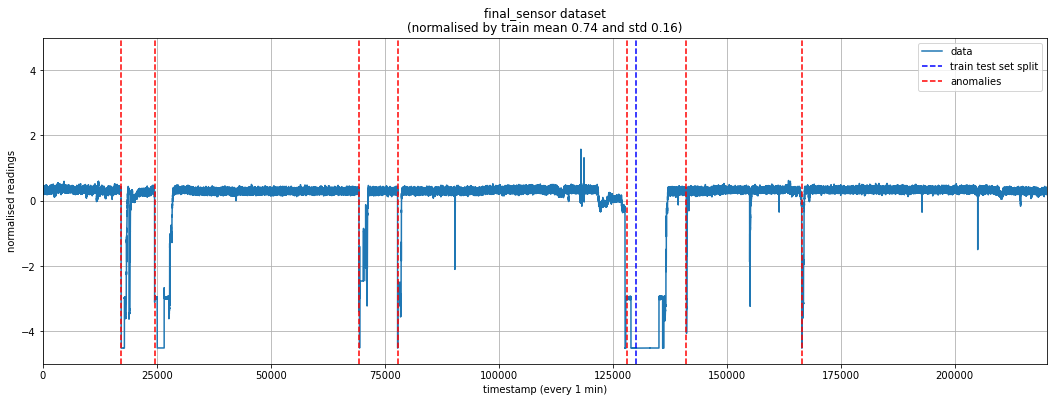

In [27]:
dataset = 'final_sensor'
idx_split = [0, 130000] # 5 anomalies

t, readings_normalised = process_and_save_specified_dataset(dataset, idx_split)

In [ ]:
labels = np.where(df['operation'] == 0, 0, 1)
labels

In [ ]:
labels.size

## LSTM (check another kernel) 

In [ ]:
normal_x = df[labels == 1] # normal or recovering
anomaly_x = df[labels == 0] # broken 

normal_y = labels[labels == 1]
anomaly_y = labels[labels == 0]

In [ ]:
print(normal_x.shape)
print(normal_y.shape)
print(anomaly_x.shape)
print(anomaly_y.shape)

In [ ]:
len_normal = len(normal_x)
len_normal_train = int(0.8 * len_normal)
x_train = normal_x[:len_normal_train]

x_test_normal = normal_x[len_normal_train:]
len_anomaly_test = len(x_test_normal)
x_test_anomaly = anomaly_x[:len_anomaly_test]

x_test = np.concatenate([x_test_normal, x_test_anomaly])
y_test = np.ones(len(x_test))
y_test[:len(x_test_normal)] = 0

In [ ]:
print(x_train.shape)
print(x_test.shape)

In [ ]:
x_train[x_train['operation'] == 0].count()

### define error 

In [ ]:
def get_error(s1, s2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((s1 - s2) ** 2, axis=1))
    return np.mean((s1 - s2) ** 2, axis=1)

### the reparameterization trick

In [ ]:
def sample(args):
    z_mean, z_log_var =args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
x_train.shape[1]

In [ ]:
original_dim = x_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = 2           # original_dim / 2
latent_dim = 1                 # original_dim / 3

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

In [ ]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

In [ ]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae')

In [ ]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(x_train, x_train,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        epochs=128,
                        batch_size=256)

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
x_train_pred = vae_model.predict(x_train)

In [ ]:
mae_vector = get_error(x_train_pred, x_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\ndataset: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

In [ ]:
x_pred = vae_model.predict(x_test)
mae_vector = get_error(x_pred, x_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))